In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("white")
import scipy 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv2D,Conv1D, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.core.pylabtools import figsize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import *
from keras import backend as K
# Set random seed for reproducibility
tf.random.set_seed(42)

In [39]:
!pip install Historic-Crypto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import warnings
warnings.filterwarnings("ignore")

from Historic_Crypto import HistoricalData

In [41]:
btc_historicals = HistoricalData('BTC-USD',86400,'2021-01-01-00-00', '2022-07-01-00-00').retrieve_data() # cyrpto name, number of seconds, start date, end date


Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2021-01-01T00:00:00
Provisional End: 2021-10-28T00:00:00
Data for chunk 1 of 2 extracted
Provisional Start: 2021-10-28T00:00:00
Provisional End: 2022-08-24T00:00:00
Data for chunk 2 of 2 extracted


In [42]:
btc_historicals.shape

(546, 5)

In [43]:
btc_historicals.tail()

,low,high,open,close,volume
time,,,,,
2022-06-27,20500.00,21520.00,21024.85,20725.17,17440.942683
2022-06-28,20164.70,21189.99,20722.95,20252.89,17658.660417
2022-06-29,19823.43,20410.91,20253.50,20094.79,18278.451859
2022-06-30,18603.00,20143.53,20098.00,19985.62,28361.458762
2022-07-01,18938.33,20879.99,19985.62,19252.76,32977.000523


In [44]:
# Check out variables
btc_historicals.dtypes

low       float64
high      float64
open      float64
close     float64
volume    float64
dtype: object

In [45]:
tst = btc_historicals

In [46]:
print('Null Values:',tst.isnull().values.sum())
print('If any NA values:', tst.isnull().values.any())

Null Values: 0
If any NA values: False


In [47]:
# Create variable '‘TOMORROW_CLOSE’' which shifts 'Close' up by 1
tst['TOMORROW_CLOSE'] = tst['close'].shift(-1,fill_value=0)

In [48]:
# drop last row because we shifted value (remember this when you add your forecasting data)
tst.drop(tst.tail(1).index,inplace=True) 

In [49]:
# Drop close column, since we created new ‘TOMORROW_CLOSE’
tst = tst.drop(columns=['close'])

In [50]:
tst.head()

,low,high,open,volume,TOMORROW_CLOSE
time,,,,,
2021-01-02,29039.00,33300.00,29413.29,46675.246521,33080.66
2021-01-03,32008.62,34810.00,32222.88,36951.716506,32019.99
2021-01-04,27678.00,33666.99,33082.84,46045.389685,34030.64
2021-01-05,29891.13,34499.67,32020.22,42282.569200,36859.26
2021-01-06,33352.54,37000.00,34043.91,45744.103200,39505.56


In [51]:
tst.shape

(545, 5)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web

In [53]:

def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['TOMORROW_CLOSE'].rolling(window=7).mean()
    dataset['ma21'] = dataset['TOMORROW_CLOSE'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['TOMORROW_CLOSE'].ewm(span=26).mean()
    dataset['12ema'] = dataset['TOMORROW_CLOSE'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['TOMORROW_CLOSE'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['TOMORROW_CLOSE'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['TOMORROW_CLOSE']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [54]:
df = get_technical_indicators(tst)

In [55]:
df = df.dropna()
df.head()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2021-01-22,28732.00,33867.00,30855.90,48155.721617,32112.01,34259.641429,35865.701429,35377.080031,34647.900062,-729.179969,2768.237573,41402.176574,30329.226283,32345.742206,32111.01,10.376954
2021-01-23,31432.19,33488.79,32982.66,16139.814783,32288.56,33755.150000,35827.982381,35096.733728,34275.485985,-821.247744,2813.115648,41454.213677,30201.751085,32307.620735,32287.56,10.382437
2021-01-24,30931.21,33086.53,32110.00,13618.800978,32261.87,33131.955714,35839.500476,34843.637701,33958.909800,-884.727901,2797.194653,41433.889782,30245.111171,32277.120245,32260.87,10.381610
2021-01-25,31920.80,34888.00,32293.18,23045.662934,32510.82,32645.318571,35767.128095,34638.483747,33732.009389,-906.474358,2865.171051,41497.470197,30036.785993,32432.920082,32509.82,10.389297
2021-01-26,30830.00,32960.37,32260.52,23535.838917,30407.13,31917.324286,35459.883810,34271.457772,33212.512918,-1058.944854,3080.085635,41620.055080,29299.712539,31082.393361,30406.13,10.322400


In [56]:
# Split train data (90%) and test data (10%)

train_size = int(len(tst)*0.90)
train_dataset, test_dataset = tst.iloc[:train_size],tst.iloc[train_size:]


In [57]:
train_dataset.head()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2021-01-02,29039.00,33300.00,29413.29,46675.246521,33080.66,NaN,NaN,33080.660000,33080.660000,0.000000,NaN,NaN,NaN,33080.660000,33079.66,10.406674
2021-01-03,32008.62,34810.00,32222.88,36951.716506,32019.99,NaN,NaN,32529.927500,32506.130417,-23.797083,NaN,NaN,NaN,32285.157500,32018.99,10.374084
2021-01-04,27678.00,33666.99,33082.84,46045.389685,34030.64,NaN,NaN,33069.118931,33101.146859,32.027929,NaN,NaN,NaN,33493.568462,34029.64,10.434987
2021-01-05,29891.13,34499.67,32020.22,42282.569200,36859.26,NaN,NaN,34128.676746,34287.436309,158.759563,NaN,NaN,NaN,35765.410250,36858.26,10.514835
2021-01-06,33352.54,37000.00,34043.91,45744.103200,39505.56,NaN,NaN,35375.598150,35705.181866,329.583716,NaN,NaN,NaN,38269.146860,39504.56,10.584171


In [58]:
print('Null Values:',train_dataset.isnull().values.sum())
train_dataset = train_dataset.dropna()
print('Null Values:',train_dataset.isnull().values.sum())

Null Values: 86
Null Values: 0


In [59]:
# Split train data to X and y
X_train = train_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]

# Split test data to X and y
X_test = test_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]

In [60]:
X_train.head()

,low,high,open,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,
2021-01-22,28732.00,33867.00,30855.90,48155.721617,34259.641429,35865.701429,35377.080031,34647.900062,-729.179969,2768.237573,41402.176574,30329.226283,32345.742206,32111.01,10.376954
2021-01-23,31432.19,33488.79,32982.66,16139.814783,33755.150000,35827.982381,35096.733728,34275.485985,-821.247744,2813.115648,41454.213677,30201.751085,32307.620735,32287.56,10.382437
2021-01-24,30931.21,33086.53,32110.00,13618.800978,33131.955714,35839.500476,34843.637701,33958.909800,-884.727901,2797.194653,41433.889782,30245.111171,32277.120245,32260.87,10.381610
2021-01-25,31920.80,34888.00,32293.18,23045.662934,32645.318571,35767.128095,34638.483747,33732.009389,-906.474358,2865.171051,41497.470197,30036.785993,32432.920082,32509.82,10.389297
2021-01-26,30830.00,32960.37,32260.52,23535.838917,31917.324286,35459.883810,34271.457772,33212.512918,-1058.944854,3080.085635,41620.055080,29299.712539,31082.393361,30406.13,10.322400


In [61]:
'''
#Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)
'''

"\n#Plot train and test data\nplt.figure(figsize = (12, 6))\nplt.rcParams['figure.dpi'] = 360\nplt.plot(train_dataset.TOMORROW_CLOSE)\nplt.plot(test_dataset.TOMORROW_CLOSE)\nplt.xlabel('Date')\nplt.ylabel('Close value (US$)')\nplt.legend(['Train set', 'Test set'], loc='upper left')\nprint('Dimension of train data: ',train_dataset.shape)\nprint('Dimension of test data: ', test_dataset.shape)\n"

In [62]:
# Different scaler for input and output ----> Normalizate the data
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [63]:
# Create 3 dimensional data set 
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 15 # which means the model will make predictions of ‘TOMORROW_CLOSE’ based on the input from the 10 previous days or future days bi-lstm or bi-gru

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (455, 15, 15)
y_train.shape:  (455, 1)
X_test.shape:  (40, 15, 15)
y_test.shape:  (40, 1)


In [64]:
# Create 1d-conv-Bi-GRU model
model_conv_bi_gru = tf.keras.models.Sequential([
                    
    # Conv Layer
    Conv1D(64, 1, activation='relu',input_shape = X_train.shape[1:]),

    # First Layer Bi-GRU
    Bidirectional(tf.keras.layers.GRU(256, activation='relu', return_sequences=False )),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])
model_conv_bi_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.85e-3),loss='mse')

In [65]:
#model_bi_lstm = create_model_bilstm()

In [66]:
# Let's check the summary of our baby model
model_conv_bi_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 15, 64)            1024      
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              494592    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 496,129
Trainable params: 496,129
Non-trainable params: 0
_________________________________________________________________


In [67]:
history_conv_bi_gru = model_conv_bi_gru.fit(X_train, y_train, epochs = 24, validation_split = 0.2,batch_size = 32, shuffle = False) # no shuffer , as its time series data

Epoch 1/24
12/12 [==============================] - 5s 140ms/step - loss: 0.2505 - val_loss: 0.0526
Epoch 2/24
12/12 [==============================] - 1s 95ms/step - loss: 0.0857 - val_loss: 0.0137
Epoch 3/24
12/12 [==============================] - 1s 96ms/step - loss: 0.0372 - val_loss: 0.0203
Epoch 4/24
12/12 [==============================] - 1s 96ms/step - loss: 0.0289 - val_loss: 0.0116
Epoch 5/24
12/12 [==============================] - 1s 99ms/step - loss: 0.0226 - val_loss: 0.0111
Epoch 6/24
12/12 [==============================] - 1s 93ms/step - loss: 0.0203 - val_loss: 0.0099
Epoch 7/24
12/12 [==============================] - 1s 94ms/step - loss: 0.0201 - val_loss: 0.0102
Epoch 8/24
12/12 [==============================] - 1s 93ms/step - loss: 0.0186 - val_loss: 0.0087
Epoch 9/24
12/12 [==============================] - 1s 93ms/step - loss: 0.0185 - val_loss: 0.0097
Epoch 10/24
12/12 [==============================] - 1s 93ms/step - loss: 0.0173 - val_loss: 0.0087
Epoch 11

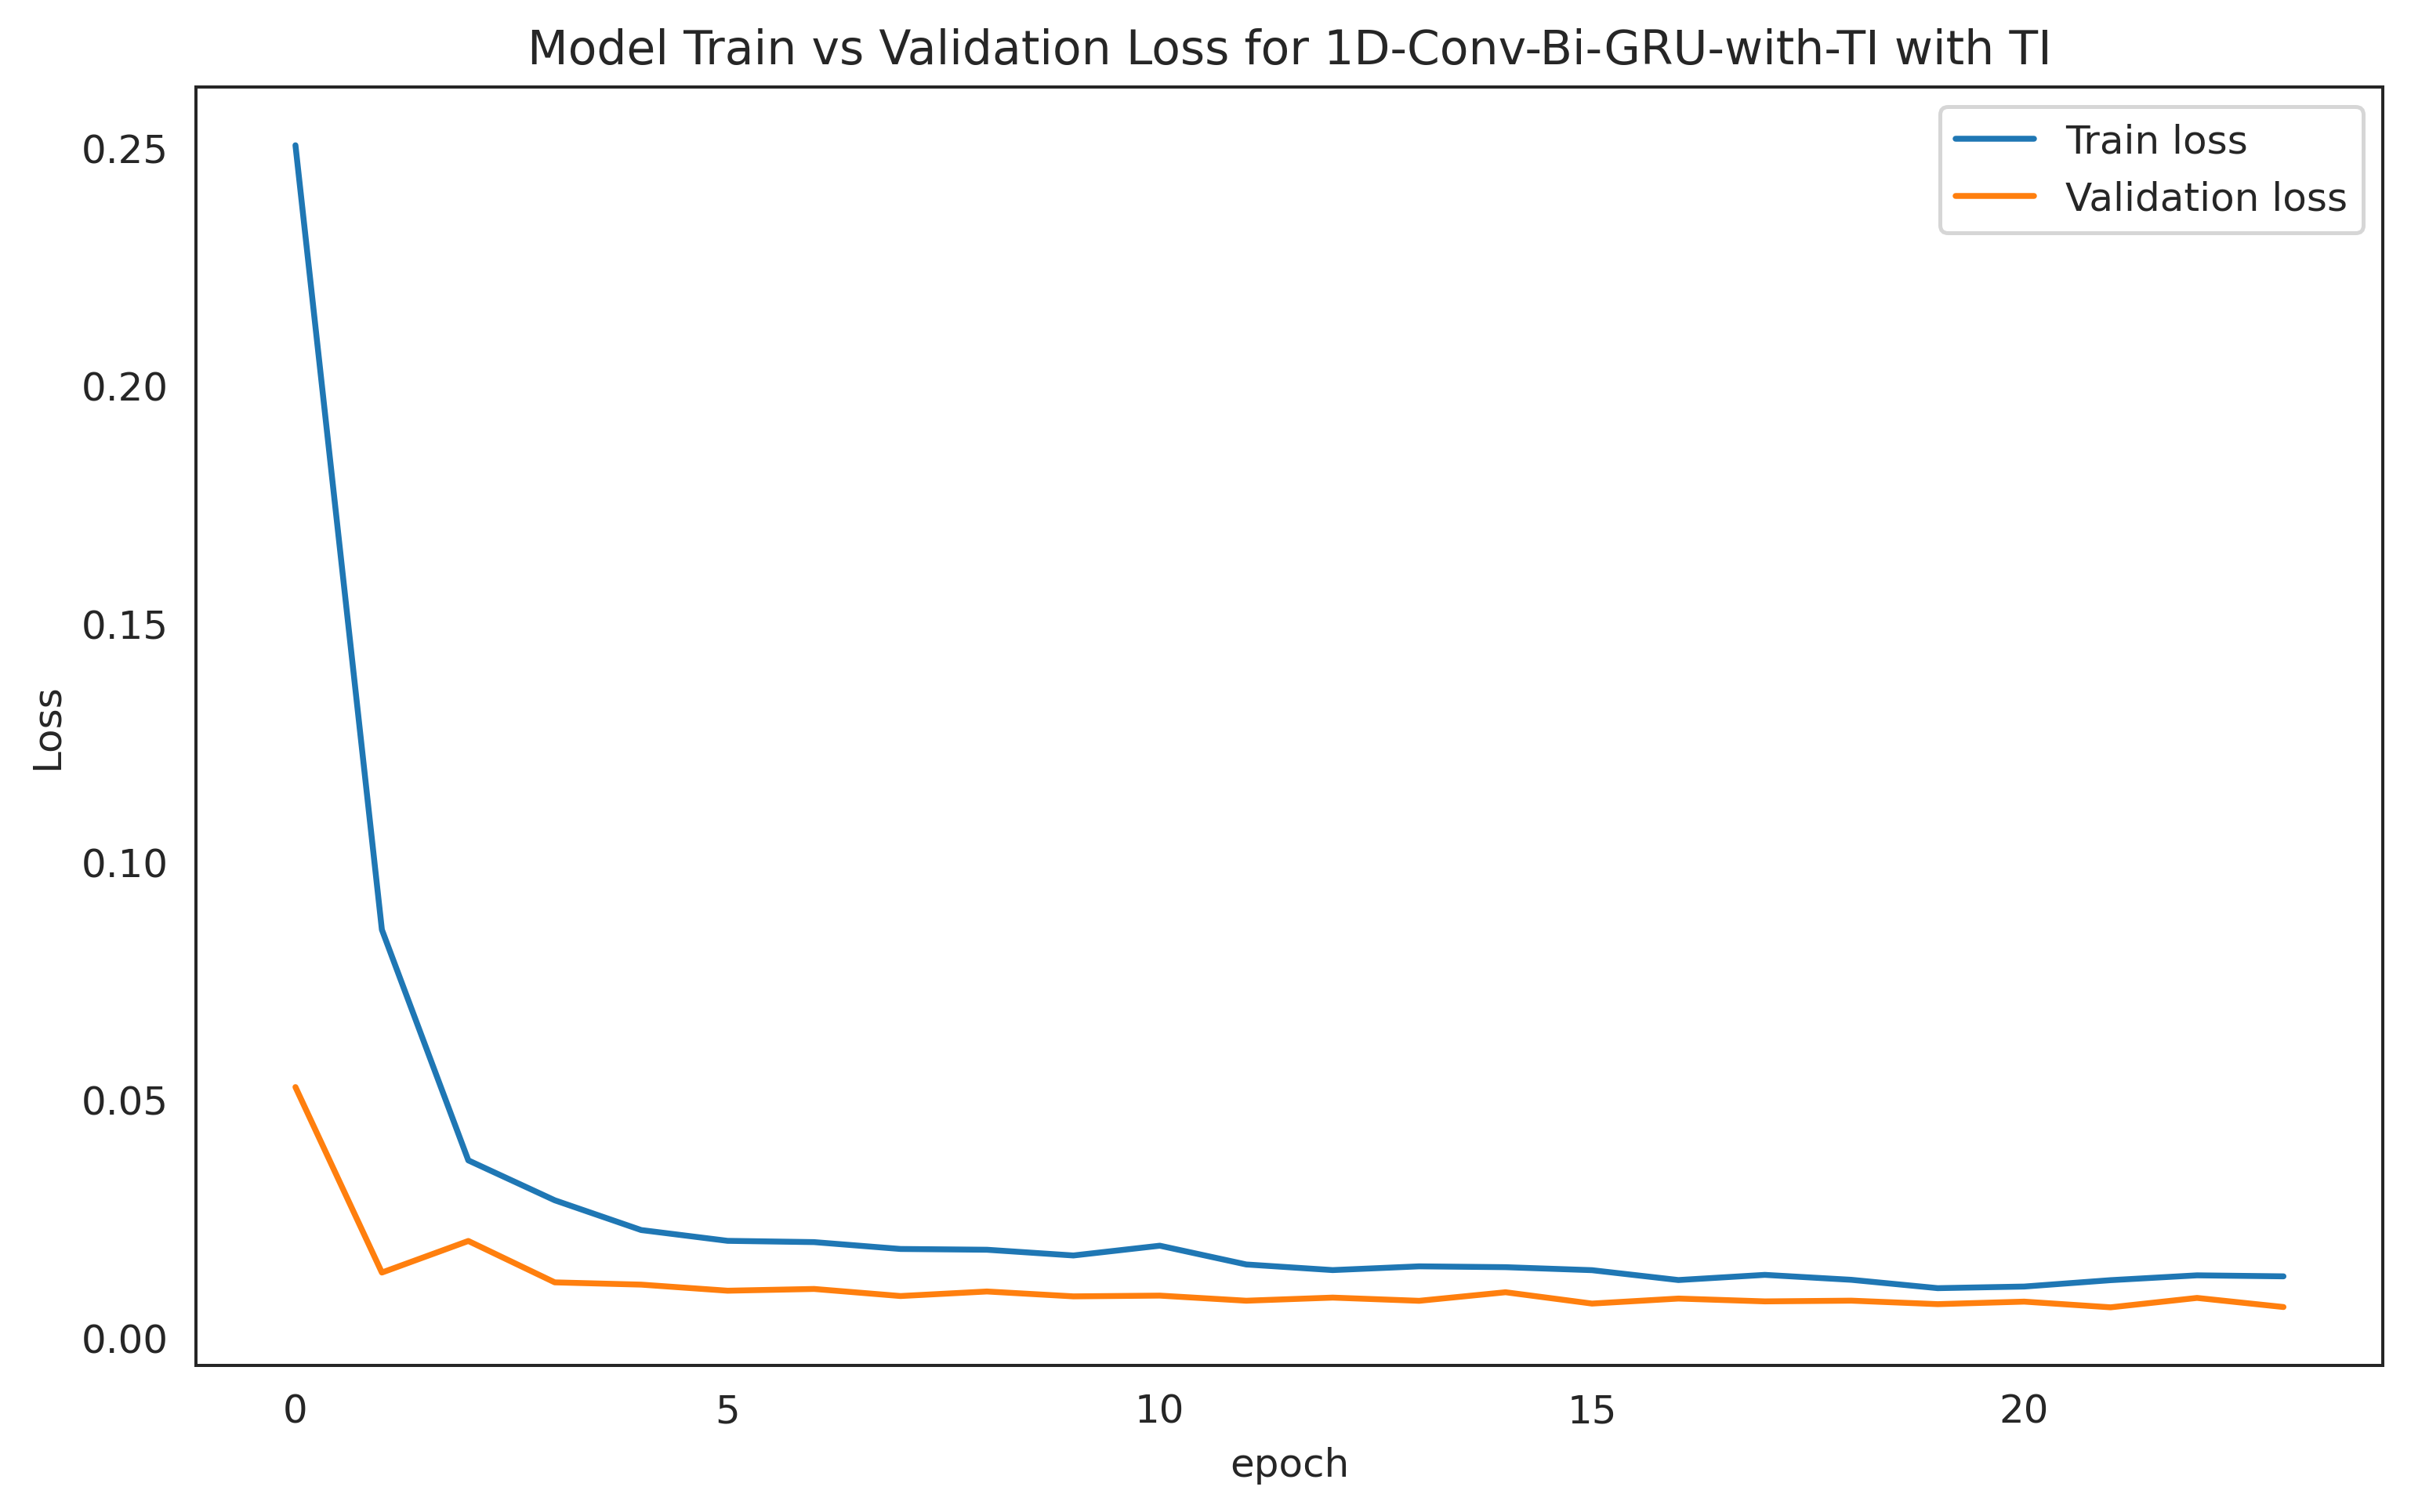

In [68]:
#Plot train and validation loss
def plot_loss (history, model_name):
    fig44 = plt.figure(figsize = (10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name + ' with TI')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    fig44.savefig('Model_Train_vs_Validation_Loss_for_Conv_Bi_GRU_with_TI.png')
plot_loss (history_conv_bi_gru, '1D-Conv-Bi-GRU-with-TI')

**Afte 30 epochs, the validation errors starts to rise, which is a sign of over fitting, therefore, one has to stop the training process at 30 epochs.**

In [69]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [70]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

In [71]:
prediction_conv_bi_gru = prediction(model_conv_bi_gru)

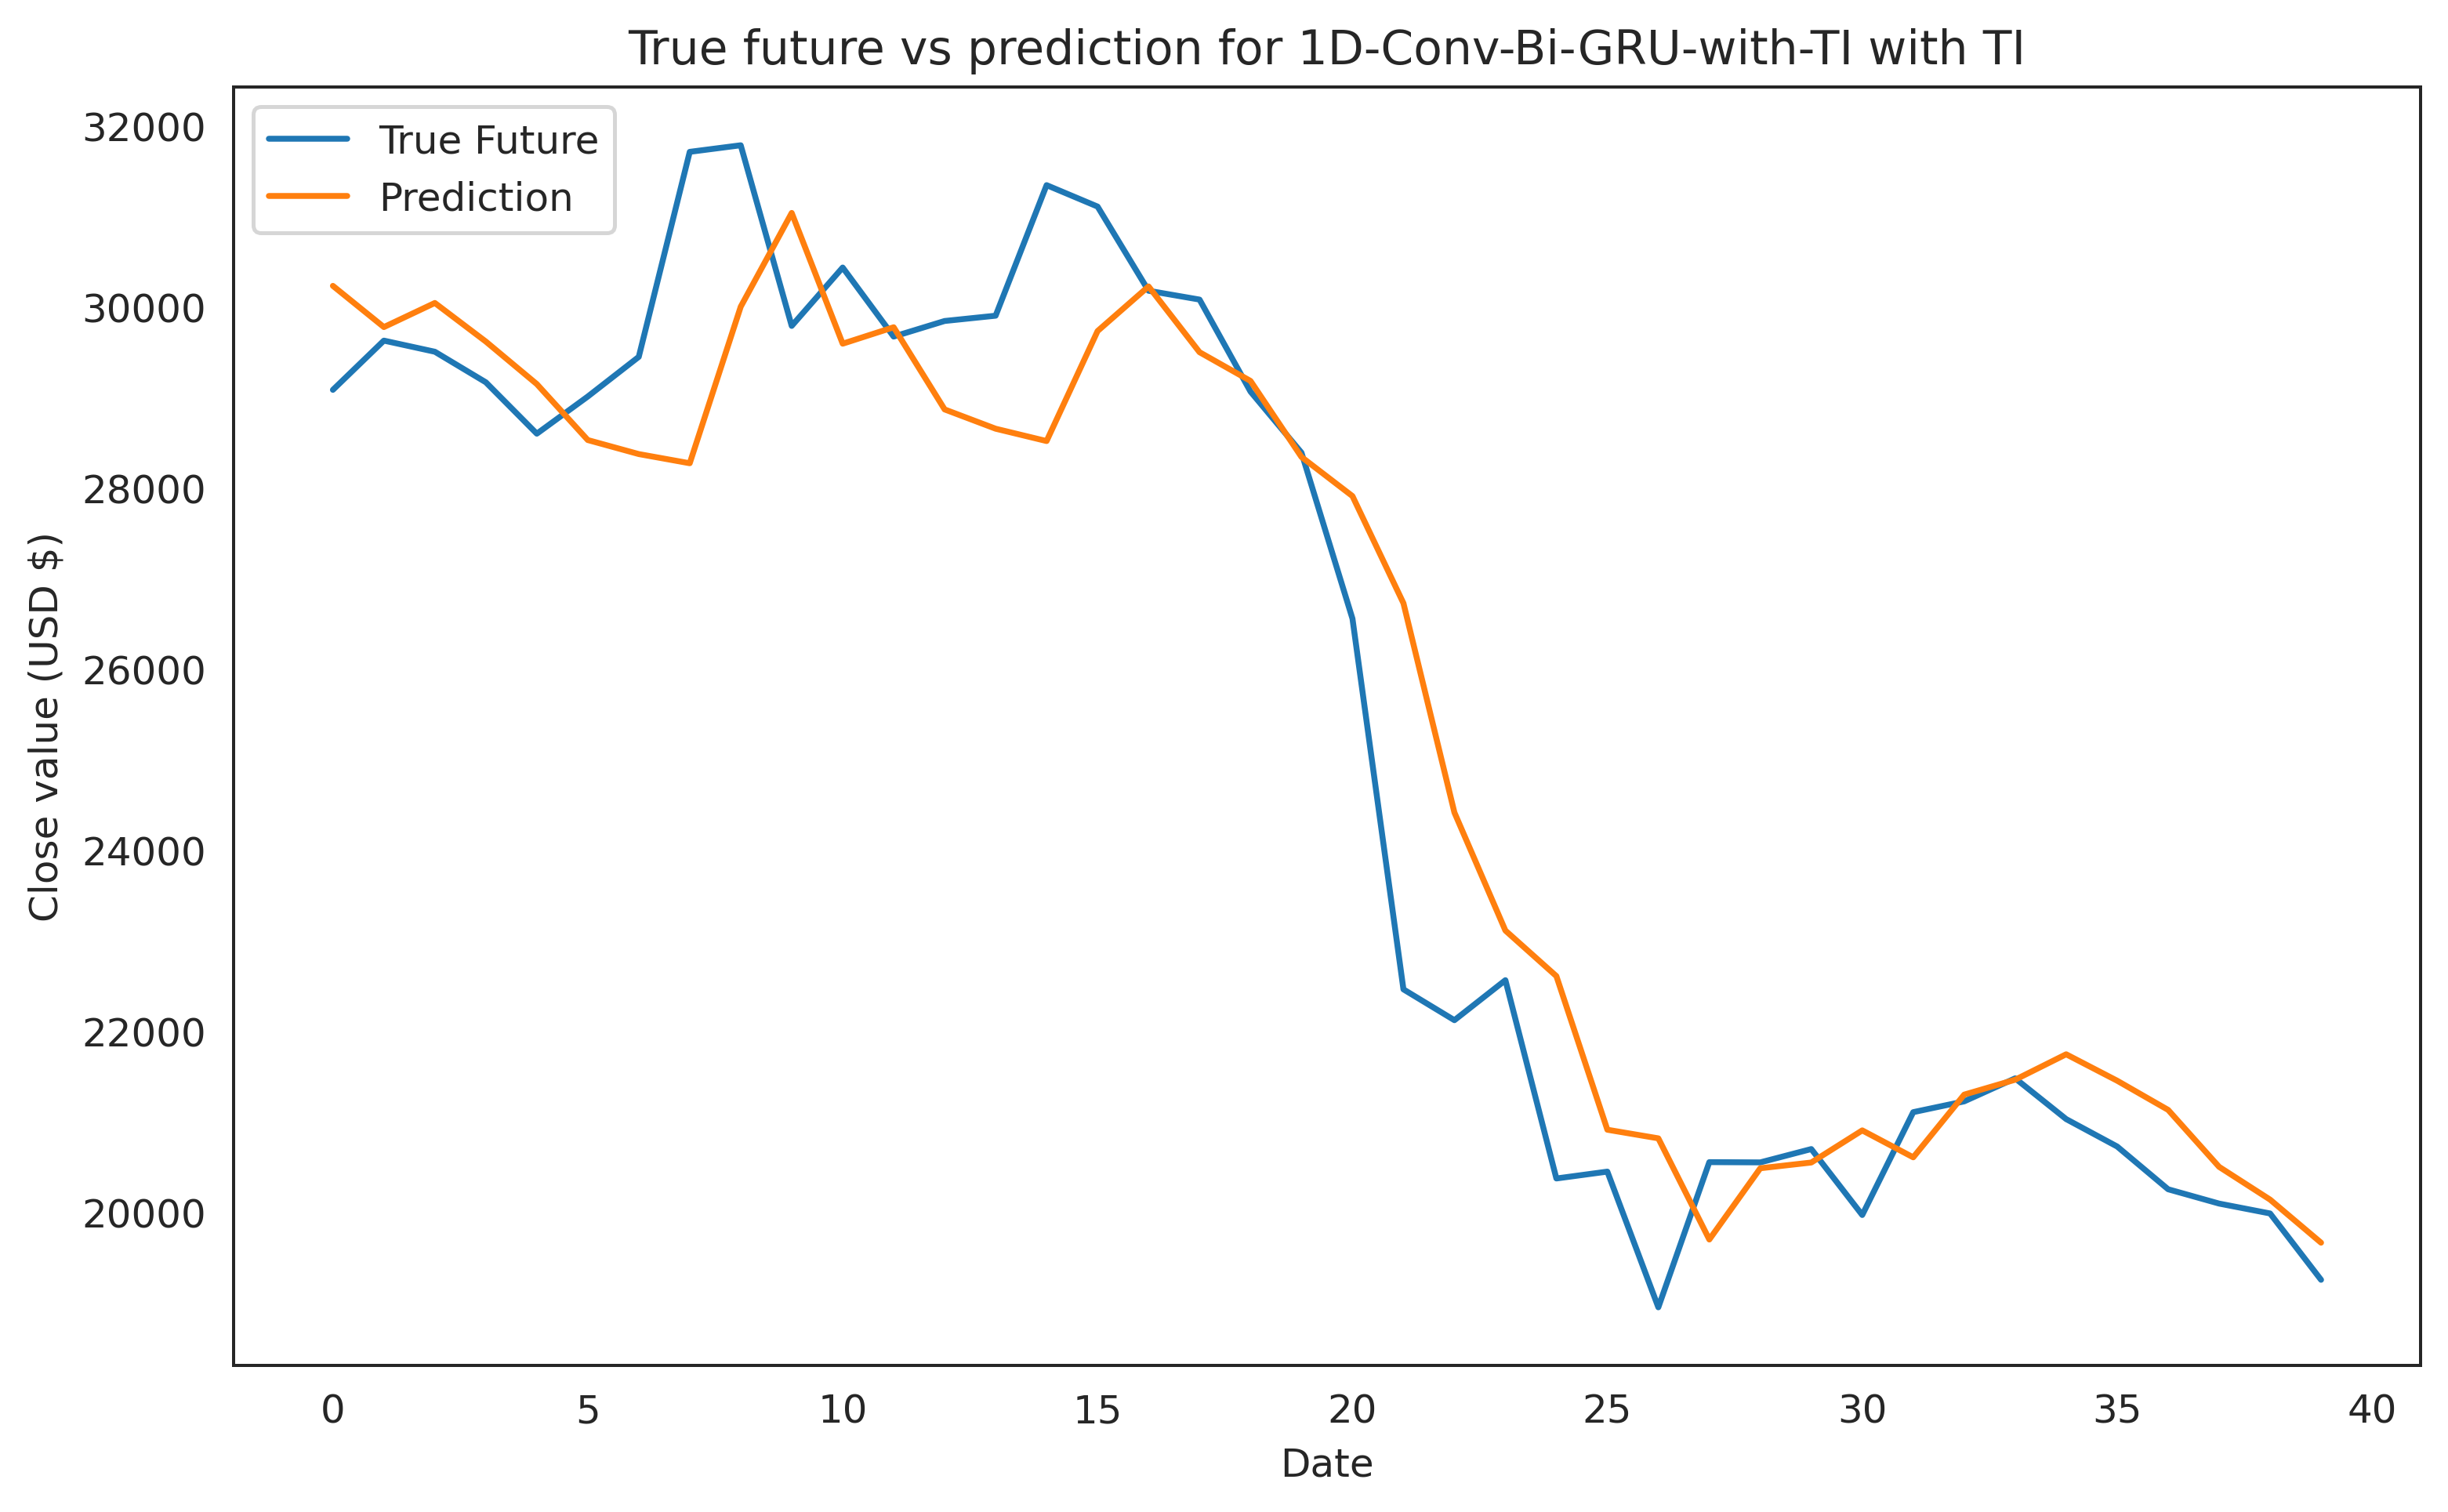

In [72]:
def plot_future(prediction, model_name, y_test):
    
    fig4 = plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name + ' with TI')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (USD $)')
    fig4.savefig('True_future_vs_prediction_for_Conv_Bi_GRU_with_TI.png')
plot_future(prediction_conv_bi_gru, '1D-Conv-Bi-GRU-with-TI', y_test)

In [73]:
## Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [74]:
evaluate_prediction(prediction_conv_bi_gru, y_test, '1D-conv-Bi-GRU-with-TI')

1D-conv-Bi-GRU-with-TI:
Mean Absolute Error: 948.2438
Root Mean Square Error: 1340.5277

